# Random Forest regressor

In [1]:
from sklearn.ensemble import RandomForestRegressor
from utils.utils_pixel import *
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm

import torch as th
import pickle
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

/dccstor/cimf/drought_impact/drought/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
n_timesteps_in = 9
n_timesteps_out = 1
n_feats_in = 85
n_feats_out = 1
exp = 'nofilter'
sample_type = 'pixel_data'
feature_set = ["MSI", "NDMI", "NDVIre", "NDWI", "B11", "B12", "B2", "B3", "B4", "B5", "B6", "B7", "B8", "B8a", "CP", "NDVI", "SCL",
               "VPDX", "VPDN", "AWVC", "MAXT", "MINT", "SR" ,"SP", "T", "TCC", "TP", 
               "DEM", 
               "CURV17", "CURV19", "CURV21", "EAST17", "EAST19", "EAST21", "NORT17", "NORT19", "NORT21", "RUGG17", "RUGG19", "RUGG21", "SLOP17", "SLOP19", "SLOP21", "TWI17", "TWI19", "TWI21",
               "CLAY0_5", "CLAY100_200", "CLAY15_30", "CLAY30_60", "CLAY5_15", "CLAY60_100",
               "FED0_5", "FED100_200", "FED15_30",  "FED30_60", "FED5_15", "FED60_100",
               "FC", "FH",
               "GRAV0_5", "GRAV100_200", "GRAV15_30", "GRAV30_60", "GRAV5_15", "GRAV60_100",
               "SAND0_5", "SAND100_200", "SAND15_30", "SAND30_60","SAND5_15", "SAND60_100",
               "SDEP",
               "CARB0_5", "CARB100_200", "CARB15_30", "CARB30_60", "CARB5_15", "CARB60_100",
               "PH0_5", "PH100_200", "PH15_30", "PH30_60","PH5_15", "PH60_100"]
remove_band = ["MSI", "NDMI", "NDVIre", "NDWI", "B11", "B12", "B2", "B3", "B4", "B5", "B6", "B7", "B8", "B8a", "SCL",
               "VPDX", "VPDN", "AWVC", "MAXT", "MINT", "SP", "TCC",
               "CURV17", "CURV19", "CURV21", "EAST17", "EAST19", "EAST21", "NORT17", "NORT19", "NORT21", "RUGG17", "RUGG19", "RUGG21", "SLOP17", "SLOP19", "SLOP21", "TWI17", "TWI19", "TWI21",
               "CLAY0_5", "CLAY100_200", "CLAY15_30", "CLAY30_60", "CLAY5_15", "CLAY60_100",
               "FED0_5", "FED100_200", "FED15_30",  "FED30_60", "FED5_15", "FED60_100",
               "FC", "FH",
               "GRAV0_5", "GRAV100_200", "GRAV15_30", "GRAV30_60", "GRAV5_15", "GRAV60_100",
               "SAND0_5", "SAND100_200", "SAND15_30", "SAND30_60","SAND5_15", "SAND60_100",
               "SDEP",
               "CARB0_5", "CARB100_200", "CARB15_30", "CARB30_60", "CARB5_15", "CARB60_100",
               "PH0_5", "PH100_200", "PH15_30", "PH30_60","PH5_15", "PH60_100"]


n_epochs = 100
n_batches = 1000
n_batches_val = 100
n_batches_te = 100
batch_size = 40

In [3]:
def get_val_metrics(rf, batch_size, n_batches_val, sample_type, exp, n_timesteps_in, n_timesteps_out, feature_set, remove_band):

    r2_tot = 0
    mse_tot = 0
    n_notmasked = 0
    
    for batch_nbr in range(n_batches_val):
        # get the current batch of data
        X_tr = np.empty([batch_size, n_timesteps_in, len(feature_set)-len(remove_band)])
        y_tr = np.empty([batch_size, n_timesteps_out, 1])

        # Load a batch here 
        img, label = load_batch(batch_size=batch_size, batch_nbr=batch_nbr, sample_type=sample_type, split='val', exp=exp, n_timesteps_out=n_timesteps_out)
        # shapes: [batch_size, n_timesteps_in, n_feats_in] and [batch_size, n_timesteps_out, n_feats_out]

        img = remove_features_batch_level(img, remove_band, feature_set)
        label = remove_features_batch_level(label, remove_band, feature_set)

        # still predict both, but dont use cp_idx for masking clouds in loss
        cp_mask = label[:,:,0,:,:].squeeze(1).squeeze(1).squeeze(1).detach()
        to_keep = 1 # NDVI only
        label = label[:,:,to_keep,:,:]

        X_tr[:, :, :] = th.reshape(img, (batch_size, img.size(dim=1), img.size(dim=2))).numpy()
        y_tr[:, :, :] = th.reshape(label, (batch_size, label.size(dim=1), label.size(dim=2))).numpy()

        # Concatenate all timesteps after each other
        X_batch = np.reshape(X_tr, (batch_size, n_timesteps_in*(len(feature_set)-len(remove_band))))
        y_batch = np.reshape(y_tr, (batch_size, n_timesteps_out*n_feats_out))

        # calculate the MSE loss
        y_pred = rf.predict(X_batch)
        # Mask out clouded vals
        y_pred_masked = y_pred[cp_mask==0]
        if len(y_pred_masked):
            mse_tot += mean_squared_error(y_batch[cp_mask==0], y_pred_masked)
        # Calculate R2 per sample
        if len(y_pred_masked):
            r2_batch = 0
            for sample in range(batch_size):
                if cp_mask[sample]<0.01:
                    y_true = np.concatenate([img[sample,:,1,:,:], label[sample,:,:,:]]).squeeze(1).squeeze(1)
                    y_pred_all = np.concatenate([img[sample,:,1,:,:].squeeze(1).squeeze(1), [y_pred[sample]]])
                    r2_batch += r2_score(y_true, y_pred_all)
            r2_tot += r2_batch/len(y_pred_masked)
            n_notmasked += len(y_pred_masked)
        

    return r2_tot/n_batches_val, mse_tot/n_batches_val, n_notmasked


def get_test_metrics(rf, batch_size, n_batches_te, sample_type, exp, n_timesteps_in, n_timesteps_out, feature_set, remove_band):
    
    r2_tot = 0
    mse_tot = 0
    
    for batch_nbr in range(n_batches_te):
        # get the current batch of data
        X_tr = np.empty([batch_size, n_timesteps_in, len(feature_set)-len(remove_band)])
        y_tr = np.empty([batch_size, n_timesteps_out, 1])

        # Load a batch here 
        img, label = load_batch(batch_size=batch_size, batch_nbr=batch_nbr, sample_type=sample_type, split='test', exp=exp, n_timesteps_out=n_timesteps_out)
        # shapes: [batch_size, n_timesteps_in, n_feats_in] and [batch_size, n_timesteps_out, n_feats_out]

        img = remove_features_batch_level(img, remove_band, feature_set)
        label = remove_features_batch_level(label, remove_band, feature_set)

        # still predict both, but dont use cp_idx for masking clouds in loss
        cp_mask = label[:,:,0,:,:].squeeze(1).squeeze(1).squeeze(1).detach()
        to_keep = 1 #NDVI only
        label = label[:,:,to_keep,:,:]
        

        X_tr[:, :, :] = th.reshape(img, (batch_size, img.size(dim=1), img.size(dim=2))).numpy()
        y_tr[:, :, :] = th.reshape(label, (batch_size, label.size(dim=1), label.size(dim=2))).numpy()

        # Concatenate all timesteps after each other
        X_batch = np.reshape(X_tr, (batch_size, n_timesteps_in*(len(feature_set)-len(remove_band))))
        y_batch = np.reshape(y_tr, (batch_size, n_timesteps_out*n_feats_out))

        # calculate the MSE loss
        y_pred = rf.predict(X_batch)
        if np.any(np.isnan(y_pred)):
            print(batch_nbr, y_pred)
        # Mask out clouded vals
        y_pred_masked = y_pred[cp_mask==0]
        if len(y_pred_masked):
            mse_tot += mean_squared_error(y_batch[cp_mask==0], y_pred_masked)
        # Calculate R2 per sample
        if len(y_pred_masked):
            r2_batch = 0
            for sample in range(batch_size):
                if cp_mask[sample]<0.01:
                    y_true = np.concatenate([img[sample,:,1,:,:], label[sample,:,:,:]]).squeeze(1).squeeze(1)
                    y_pred_all = np.concatenate([img[sample,:,1,:,:].squeeze(1).squeeze(1), [y_pred[sample]]])
                    r2_batch += r2_score(y_true, y_pred_all)
            r2_tot += r2_batch/len(y_pred_masked)

    return r2_tot/n_batches_te, mse_tot/n_batches_te

In [6]:
rf = RandomForestRegressor(random_state=42)


for epoch in tqdm(range(1)):
    for batch_nbr in range(n_batches): #
        # get the current batch of data
        X_tr = np.empty([batch_size, n_timesteps_in, len(feature_set)-len(remove_band)])
        y_tr = np.empty([batch_size, n_timesteps_out, 1])

        # Load a batch here 
        img, label = load_batch(batch_size=batch_size, batch_nbr=batch_nbr, sample_type=sample_type, split='train', exp=exp, n_timesteps_out=n_timesteps_out)
        # shapes: [batch_size, n_timesteps_in, n_feats_in] and [batch_size, n_timesteps_out, n_feats_out]

        img = remove_features_batch_level(img, remove_band, feature_set)
        label = remove_features_batch_level(label, remove_band, feature_set)

        # still predict both, but dont use cp_idx for masking clouds in loss
        to_keep = 1
        label = label[:,:,to_keep,:,:]

        X_tr[:, :, :] = th.reshape(img, (batch_size, img.size(dim=1), img.size(dim=2))).numpy()
        y_tr[:, :, :] = th.reshape(label, (batch_size, label.size(dim=1), label.size(dim=2))).numpy()

        # Concatenate all timesteps after each other
        X_batch = np.reshape(X_tr, (batch_size, n_timesteps_in*(len(feature_set)-len(remove_band))))
        y_batch = np.reshape(y_tr, (batch_size, n_timesteps_out*n_feats_out))

        # fit the regressor on the current batch
        rf.fit(X_batch, y_batch.ravel())
        
    
    r2, mse, n_notmasked = get_val_metrics(rf, batch_size, n_batches_val, sample_type, exp, n_timesteps_in, n_timesteps_out, feature_set, remove_band)
    print(f'Validation metrics for epoch {epoch}: R2 {r2}. MSE {mse}. n points {n_notmasked}') 

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [05:39<00:00, 339.67s/it]

Validation metrics for epoch 0: R2 0.7807879326040476. MSE 0.07897778991146202. n points 903


In [4]:
"""
# Save model for future use
with open('RF_cp.pkl', 'wb') as f:
    pickle.dump(rf, f)
"""
with open('RF_cp.pkl', 'rb') as f:
    rf = pickle.load(f)


In [5]:
# Evaluate on val set

r2_val, mse_val, _ = get_val_metrics(rf, batch_size, n_batches_val, sample_type, exp, n_timesteps_in, n_timesteps_out, feature_set, remove_band)
print(f"Test MSE: {mse_val}, test R2: {r2_val}")

Test MSE: 0.07897778991146202, test R2: 0.7807879326040476


In [9]:
# Evaluate on test set

r2_test, mse_test = get_test_metrics(rf, batch_size, n_batches_te, sample_type, exp, n_timesteps_in, n_timesteps_out, feature_set, remove_band)
print(f"Test MSE: {mse_test}, test R2: {r2_test}")

Test MSE: 0.07597878217160126, test R2: 0.68419513505642


# Plot predictions

In [28]:
exp = 'nofilter'
batch = 0
batch_size = 40 
split = 'test'

metadata_path = f'pixel_data/nofilter/{split}/'

# Get date/range of pred
all_loc_dates_files = sorted([f for f in os.listdir(metadata_path) if f.startswith('all_loc_dates')])

all_loc_dates = []
for f in all_loc_dates_files:
    with open(metadata_path+f, 'rb') as f :
        all_loc_dates += pickle.load(f)
    
n_rep = 4000/len(all_loc_dates)
idx_start = int(np.floor((batch_size*batch)/n_rep))
idx_last = int(np.floor((batch_size*batch + batch_size)/n_rep))

In [29]:
all_loc_dates[idx_start][1] 

['2020-05-04',
 '2020-05-14',
 '2020-05-24',
 '2020-06-03',
 '2020-06-13',
 '2020-06-23',
 '2020-07-03',
 '2020-07-13',
 '2020-07-23']

In [30]:
# Plot some preds on the test set

# Load a batch here 
img_raw, label_raw = load_batch(batch_size=batch_size, batch_nbr=batch, sample_type=sample_type, split=split, exp=exp, n_timesteps_out=n_timesteps_out)
# shapes: [batch_size, n_timesteps_in, n_feats_in] and [batch_size, n_timesteps_out, n_feats_out]

img = remove_features_batch_level(img_raw, remove_band, feature_set)
#label = remove_features_batch_level(label, remove_band, feature_set)

# still predict both, but dont use cp_idx for masking clouds in loss
to_keep = 1
label = label_raw[:,:,to_keep,:,:]

X_tr[:, :, :] = th.reshape(img, (batch_size, img.size(dim=1), img.size(dim=2))).numpy()
y_tr[:, :, :] = th.reshape(label, (batch_size, label.size(dim=1), label.size(dim=2))).numpy()

# Concatenate all timesteps after each other
X_batch = np.reshape(X_tr, (batch_size, n_timesteps_in*(len(feature_set)-len(remove_band))))
y_batch = np.reshape(y_tr, (batch_size, n_timesteps_out*n_feats_out))

# calculate the MSE loss
y_pred = rf.predict(X_batch)

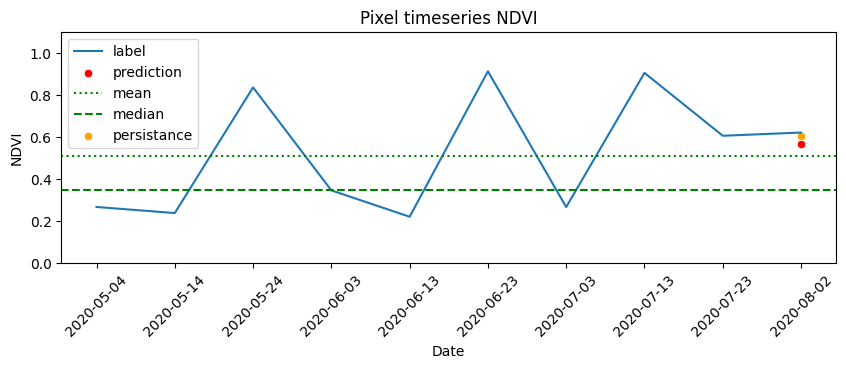

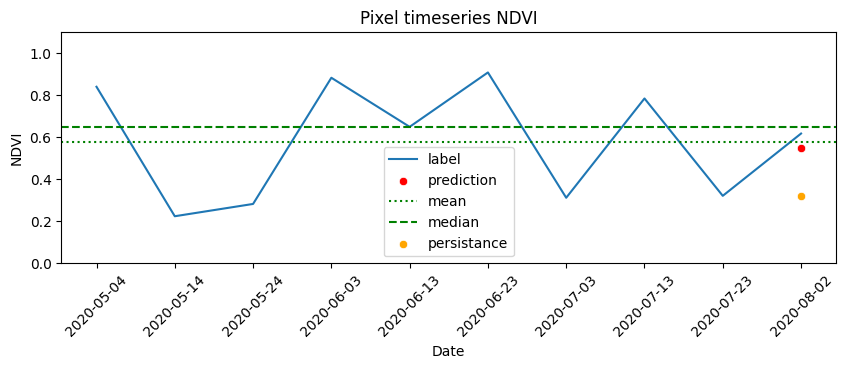

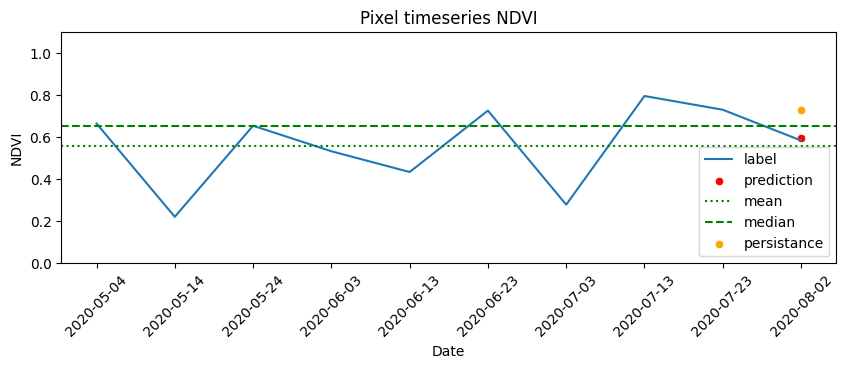

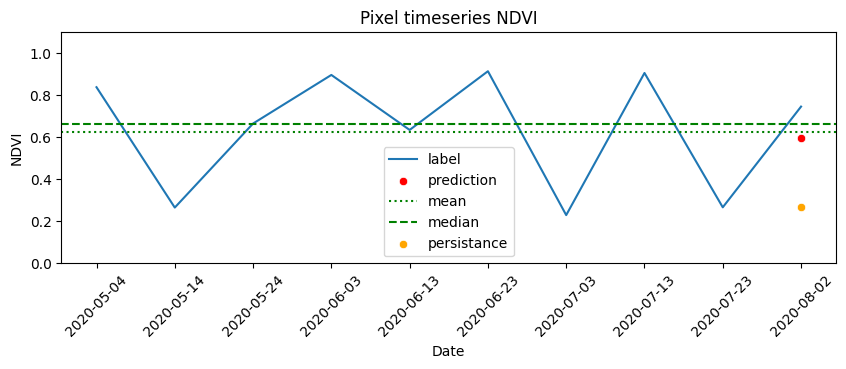

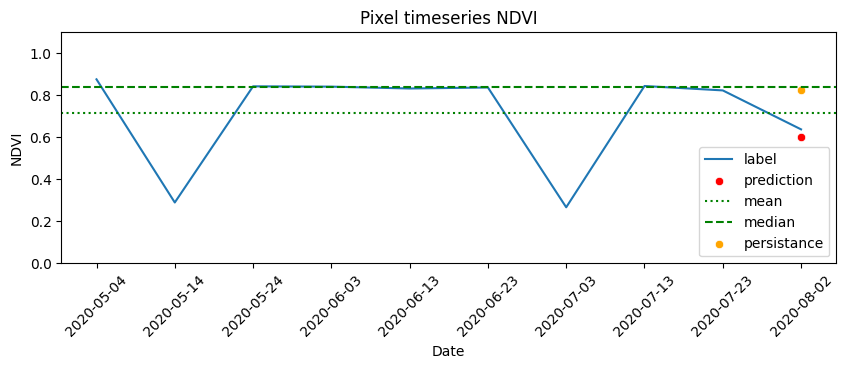

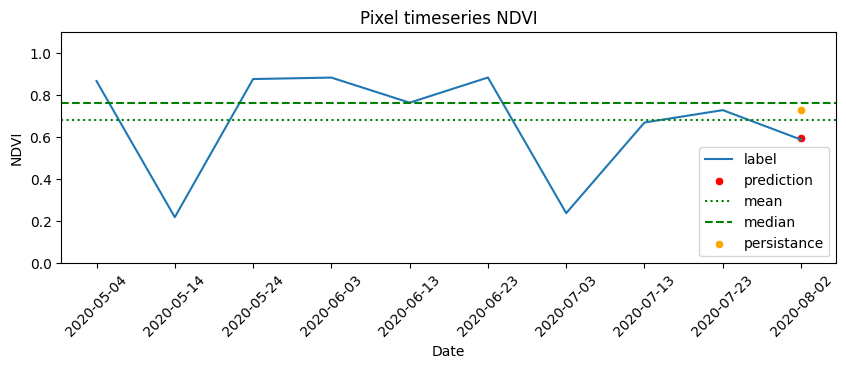

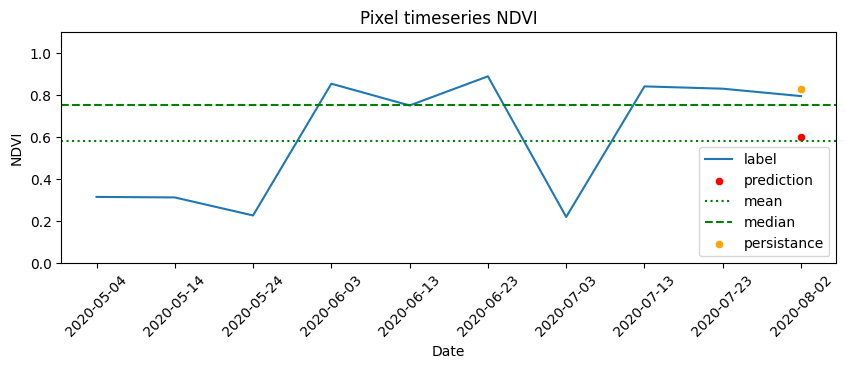

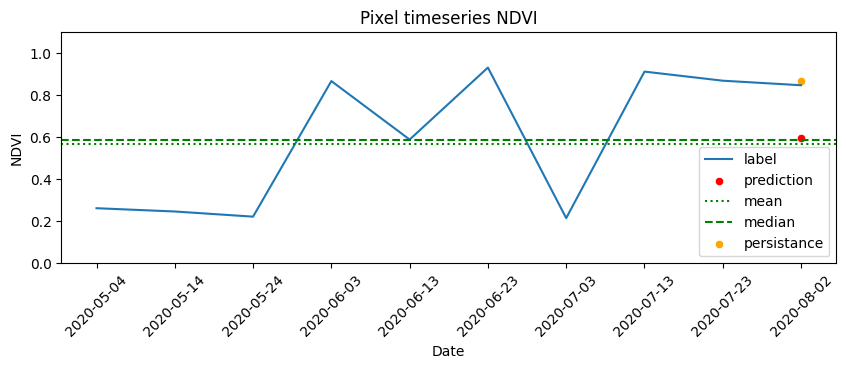

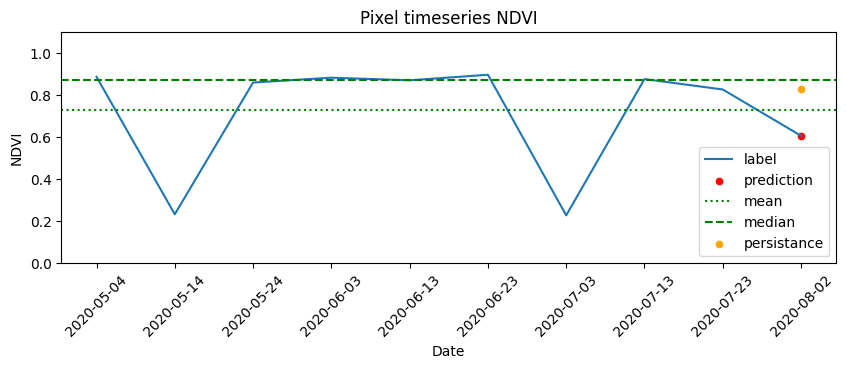

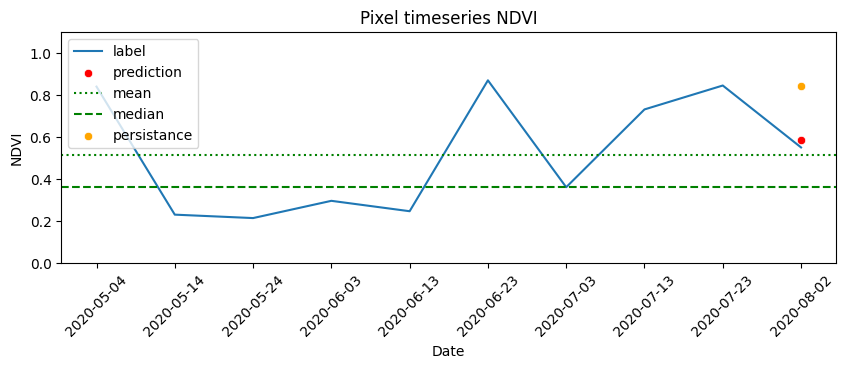

In [31]:
for sample_id in range(10):
    ndvi_input = img[sample_id, :, 1, :, :].squeeze(1).squeeze(1)
    ndvi_label = label[sample_id, :, :, :].squeeze(1).squeeze(1)
    ndvi_cleaned = th.cat([ndvi_input, ndvi_label])
    dates = all_loc_dates[idx_start][1] + all_loc_dates[idx_start][3][:1]

    pix_pred = y_pred[sample_id]
    tensor_of_nans = th.full(ndvi_input.shape, float('nan')).numpy()
    #print(tensor_of_nans.shape, [pix_pred].shape)
    pix_pred = np.concatenate([tensor_of_nans, [pix_pred]])

    fig, ax = plt.subplots(1,1,figsize=(10,3))
    plt.title('Pixel timeseries NDVI')
    sns.lineplot(ax=ax, y=ndvi_cleaned, x=dates,label='label')
    # add dot of predicted NDVI 
    sns.scatterplot(ax=ax, y=pix_pred, x=dates,label='prediction', color='red')
    # add mean and median
    plt.axhline(y = ndvi_input.mean(), color = 'green', linestyle = ':', label='mean')
    plt.axhline(y = ndvi_input.median(), color = 'green', linestyle = '--', label='median')
    # add dot of persistance prediction  
    pix_pers = ndvi_input[-1].detach().unsqueeze(0)
    tensor_of_nans = th.full(ndvi_input.shape, float('nan'))
    pix_pers = th.cat([tensor_of_nans, pix_pers])
    sns.scatterplot(ax=ax, y=pix_pers, x=dates,label='persistance', color='orange')
    
    plt.xlabel('Date')
    plt.ylabel('NDVI')
    plt.ylim(0,1.1)
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

# Residuals

In [5]:
def get_pred_label(rf, split, batch_size, n_batches, sample_type, exp, n_timesteps_in, n_timesteps_out, feature_set, remove_band):
    
    y_pred_all = list()
    label_all = list()
    
    for batch_nbr in range(n_batches):
        # get the current batch of data
        X_tr = np.empty([batch_size, n_timesteps_in, len(feature_set)-len(remove_band)])
        y_tr = np.empty([batch_size, n_timesteps_out, 1])

        # Load a batch here
        img, label = load_batch(batch_size=batch_size, batch_nbr=batch_nbr, sample_type=sample_type, split=split, exp=exp, n_timesteps_out=n_timesteps_out)
        # shapes: [batch_size, n_timesteps_in, n_feats_in] and [batch_size, n_timesteps_out, n_feats_out]

        img = remove_features_batch_level(img, remove_band, feature_set)
        label = remove_features_batch_level(label, remove_band, feature_set)

        # still predict both, but dont use cp_idx for masking clouds in loss
        to_keep = 1 #NDVI only
        label = label[:,:,to_keep,:,:]

        X_tr[:, :, :] = th.reshape(img, (batch_size, img.size(dim=1), img.size(dim=2))).numpy()
        y_tr[:, :, :] = th.reshape(label, (batch_size, label.size(dim=1), label.size(dim=2))).numpy()

        # Concatenate all timesteps after each other
        X_batch = np.reshape(X_tr, (batch_size, n_timesteps_in*(len(feature_set)-len(remove_band))))
        y_batch = np.reshape(y_tr, (batch_size, n_timesteps_out*n_feats_out))
        

        # calculate the MSE loss
        y_pred = rf.predict(X_batch)
        
        y_pred_all.append(y_pred)
        label_all.append(label)
        
        
    return y_pred_all, label_all

In [6]:
split = 'val'
batch_size = 40
n_batches = 100

y_pred_val, label_val = get_pred_label(rf, split, batch_size, n_batches, sample_type, exp, n_timesteps_in, n_timesteps_out, feature_set, remove_band)
y_pred_val = np.concatenate(y_pred_val)
label_val = np.concatenate(label_val).squeeze(1).squeeze(1).squeeze(1) 

KeyboardInterrupt: 

In [ ]:
split = 'test'
batch_size = 40
n_batches = 100

y_pred_test, label_test = get_pred_label(rf, split, batch_size, n_batches, sample_type, exp, n_timesteps_in, n_timesteps_out, feature_set, remove_band)
y_pred_test = np.concatenate(y_pred_test)
label_test = np.concatenate(label_test).squeeze(1).squeeze(1).squeeze(1)

In [ ]:
split = 'train'
batch_size = 40
n_batches = 1000

y_pred_train, label_train = get_pred_label(rf, split, batch_size, n_batches, sample_type, exp, n_timesteps_in, n_timesteps_out, feature_set, remove_band)
y_pred_train = np.concatenate(y_pred_train)
label_train = np.concatenate(label_train).squeeze(1).squeeze(1).squeeze(1)

In [10]:
# Residual vs label ndvi

df = pd.DataFrame(data=label_test, columns=['label'], index=np.arange(0,len(label_test),1))
df['pred'] = y_pred_test
df['set'] = ['test']*len(label_test)

df_val = pd.DataFrame(data=label_val, columns=['label'], index=np.arange(0,len(label_val),1))
df_val['pred'] = y_pred_val
df_val['set'] = ['val']*len(label_val)

df_tr = pd.DataFrame(data=label_train, columns=['label'], index=np.arange(0,len(label_train),1))
df_tr['pred'] = y_pred_train
df_tr['set'] = ['train']*len(label_train)

df_all = pd.concat([df_tr, df_val, df], axis=0, ignore_index=True)
df_all['res'] = df_all['label'] - df_all['pred']

Text(0, 0.5, 'Residual')

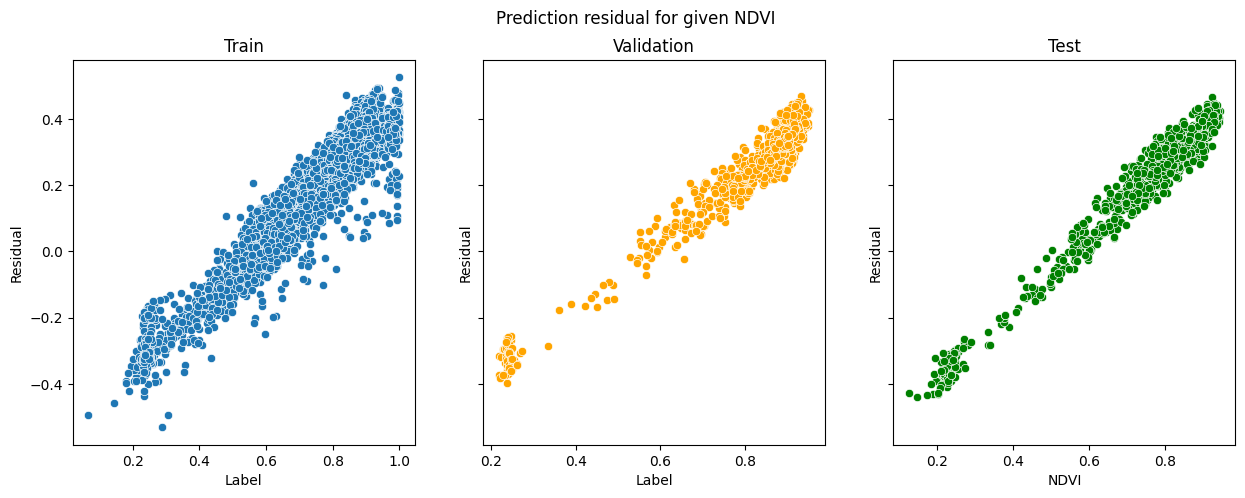

In [7]:
fig, axs = plt.subplots(1,3,figsize=(15,5), sharey=True)
plt.suptitle('Prediction residual for given NDVI')
axs[0].set_title('Train')
axs[0].set_xlabel('Label')
axs[0].set_ylabel('Residual')
sns.scatterplot(ax=axs[0], y='res', x='label', data=df_all[df_all.set=='train'])
axs[1].set_title('Validation')
axs[1].set_xlabel('Label')
axs[1].set_ylabel('Residual')
sns.scatterplot(ax=axs[1], y='res', x='label', data=df_all[df_all.set=='val'], color='orange')
axs[2].set_title('Test')
axs[2].set_xlabel('Label')
axs[2].set_ylabel('Residual')
sns.scatterplot(ax=axs[2], y='res', x='label', data=df_all[df_all.set=='test'], color='green')
plt.xlabel('NDVI')
plt.ylabel('Residual')

Text(0, 0.5, 'Pred')

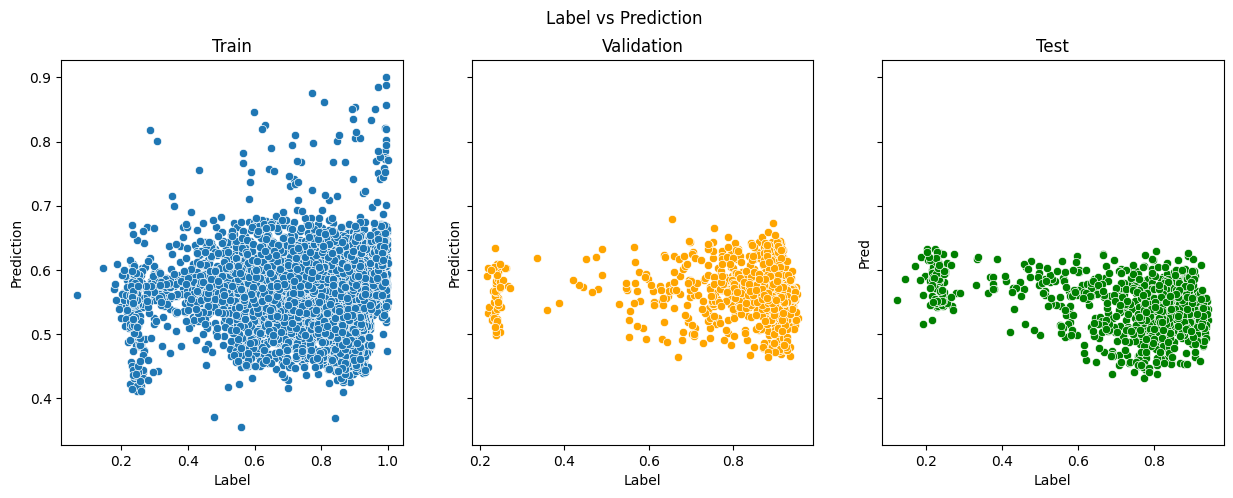

In [8]:
# Plot: pred vs label

fig, axs = plt.subplots(1,3,figsize=(15,5), sharey=True)
plt.suptitle('Label vs Prediction')
axs[0].set_title('Train')
axs[0].set_xlabel('Label')
axs[0].set_ylabel('Prediction')
sns.scatterplot(ax=axs[0],  y='pred', x='label', data=df_all[df_all.set=='train'])
axs[1].set_title('Validation')
axs[1].set_xlabel('Label')
axs[1].set_ylabel('Prediction')
sns.scatterplot(ax=axs[1], y='pred', x='label', data=df_all[df_all.set=='val'], color='orange')
axs[2].set_title('Test')
axs[2].set_xlabel('Label')
axs[2].set_ylabel('Prediction')
sns.scatterplot(ax=axs[2],  y='pred', x='label', data=df_all[df_all.set=='test'], color='green')
plt.xlabel('Label')
plt.ylabel('Pred')

# Mask out labels and corresponding preds if cloud covered

In [7]:
def get_pred_label(rf, split, batch_size, n_batches, sample_type, exp, n_timesteps_in, n_timesteps_out, feature_set, remove_band):
    
    y_pred_all = list()
    label_all = list()
    
    for batch_nbr in range(n_batches):
        # get the current batch of data
        X_tr = np.empty([batch_size, n_timesteps_in, len(feature_set)-len(remove_band)])
        y_tr = np.empty([batch_size, n_timesteps_out, 1])

        # Load a batch here
        img, label = load_batch(batch_size=batch_size, batch_nbr=batch_nbr, sample_type=sample_type, split=split, exp=exp, n_timesteps_out=n_timesteps_out)
        # shapes: [batch_size, n_timesteps_in, n_feats_in] and [batch_size, n_timesteps_out, n_feats_out]

        img = remove_features_batch_level(img, remove_band, feature_set)
        label = remove_features_batch_level(label, remove_band, feature_set)

        # still predict both, but dont use cp_idx for masking clouds in loss
        cp_mask = label[:,:,0,:,:].squeeze(1).squeeze(1).squeeze(1)
        to_keep = 1 #NDVI only
        label = label[:,:,to_keep,:,:]

        X_tr[:, :, :] = th.reshape(img, (batch_size, img.size(dim=1), img.size(dim=2))).numpy()
        y_tr[:, :, :] = th.reshape(label, (batch_size, label.size(dim=1), label.size(dim=2))).numpy()

        # Concatenate all timesteps after each other
        X_batch = np.reshape(X_tr, (batch_size, n_timesteps_in*(len(feature_set)-len(remove_band))))
        y_batch = np.reshape(y_tr, (batch_size, n_timesteps_out*n_feats_out))
        

        # calculate the MSE loss
        y_pred = rf.predict(X_batch)
        
        y_pred_all.append(y_pred[cp_mask<0.01])
        label_all.append(label[cp_mask<0.01])
        
        
    return y_pred_all, label_all

In [8]:
split = 'val'
batch_size = 40
n_batches = 100

y_pred_val, label_val = get_pred_label(rf, split, batch_size, n_batches, sample_type, exp, n_timesteps_in, n_timesteps_out, feature_set, remove_band)
y_pred_val = np.concatenate(y_pred_val)
label_val = np.concatenate(label_val).squeeze(1).squeeze(1).squeeze(1) 

split = 'test'
batch_size = 40
n_batches = 100

y_pred_test, label_test = get_pred_label(rf, split, batch_size, n_batches, sample_type, exp, n_timesteps_in, n_timesteps_out, feature_set, remove_band)
y_pred_test = np.concatenate(y_pred_test)
label_test = np.concatenate(label_test).squeeze(1).squeeze(1).squeeze(1)

split = 'train'
batch_size = 40
n_batches = 1000

y_pred_train, label_train = get_pred_label(rf, split, batch_size, n_batches, sample_type, exp, n_timesteps_in, n_timesteps_out, feature_set, remove_band)
y_pred_train = np.concatenate(y_pred_train)
label_train = np.concatenate(label_train).squeeze(1).squeeze(1).squeeze(1)

# Residual vs label ndvi

df = pd.DataFrame(data=label_test, columns=['label'], index=np.arange(0,len(label_test),1))
df['pred'] = y_pred_test
df['set'] = ['test']*len(label_test)

df_val = pd.DataFrame(data=label_val, columns=['label'], index=np.arange(0,len(label_val),1))
df_val['pred'] = y_pred_val
df_val['set'] = ['val']*len(label_val)

df_tr = pd.DataFrame(data=label_train, columns=['label'], index=np.arange(0,len(label_train),1))
df_tr['pred'] = y_pred_train
df_tr['set'] = ['train']*len(label_train)

df_all = pd.concat([df_tr, df_val, df], axis=0, ignore_index=True)
df_all['res'] = df_all['label'] - df_all['pred']

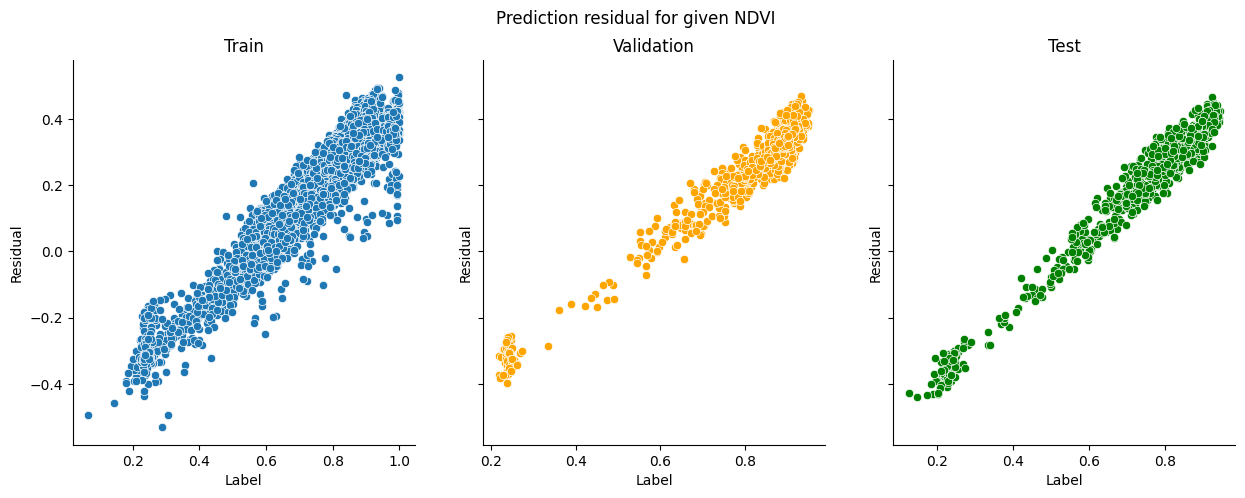

In [7]:
fig, axs = plt.subplots(1,3,figsize=(15,5), sharey=True)
plt.suptitle('Prediction residual for given NDVI')
axs[0].set_title('Train')
axs[0].set_xlabel('Label')
axs[0].set_ylabel('Residual')
sns.scatterplot(ax=axs[0], y='res', x='label', data=df_all[df_all.set=='train'])
axs[1].set_title('Validation')
axs[1].set_xlabel('Label')
axs[1].set_ylabel('Residual')
sns.scatterplot(ax=axs[1], y='res', x='label', data=df_all[df_all.set=='val'], color='orange')
axs[2].set_title('Test')
axs[2].set_xlabel('Label')
axs[2].set_ylabel('Residual')
sns.scatterplot(ax=axs[2], y='res', x='label', data=df_all[df_all.set=='test'], color='green')
sns.despine(top=True, right=True)

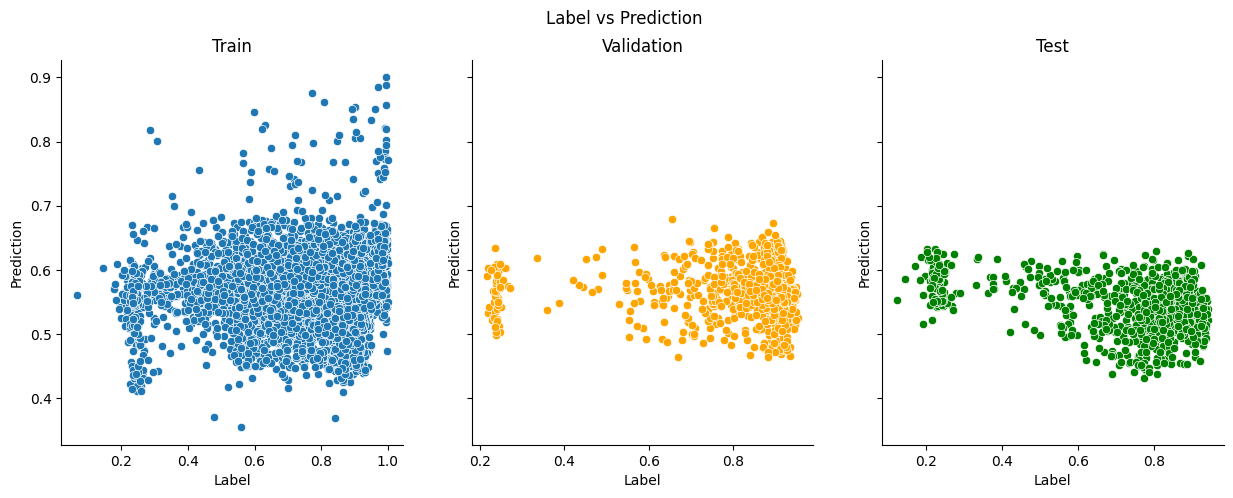

In [8]:
# Plot: pred vs label

fig, axs = plt.subplots(1,3,figsize=(15,5), sharey=True)
plt.suptitle('Label vs Prediction')
axs[0].set_title('Train')
axs[0].set_xlabel('Label')
axs[0].set_ylabel('Prediction')
sns.scatterplot(ax=axs[0],  y='pred', x='label', data=df_all[df_all.set=='train'])
axs[1].set_title('Validation')
axs[1].set_xlabel('Label')
axs[1].set_ylabel('Prediction')
sns.scatterplot(ax=axs[1], y='pred', x='label', data=df_all[df_all.set=='val'],color='orange')
axs[2].set_title('Test')
axs[2].set_xlabel('Label')
axs[2].set_ylabel('Prediction')
sns.scatterplot(ax=axs[2],  y='pred', x='label', data=df_all[df_all.set=='test'], color='green')
sns.despine(top=True, right=True)

In [6]:
# Calculate R2

r2_val = r2_score(df_all[df_all["set"]=='val'].label, df_all[df_all["set"]=='val'].pred)
r2_test = r2_score(df_all[df_all["set"]=='test'].label, df_all[df_all["set"]=='test'].pred)
r2_train = r2_score(df_all[df_all["set"]=='train'].label, df_all[df_all["set"]=='train'].pred)
print(f'R2 train {r2_train}, val {r2_val}, test {r2_test}')

R2 train -3.188286465371265, val -1.876781157877455, test -0.6569269168064498


In [9]:
# Calculate r2

import scipy.stats as stats

# Calculate Pearson's r correlation coefficient and the p-value
r_val, _ = stats.pearsonr(df_all[df_all["set"]=='val'].label, df_all[df_all["set"]=='val'].pred)
r_test, _ = stats.pearsonr(df_all[df_all["set"]=='test'].label, df_all[df_all["set"]=='test'].pred)
r_train, _ = stats.pearsonr(df_all[df_all["set"]=='train'].label, df_all[df_all["set"]=='train'].pred)

# Print the results
print(f"Pearson's r: train {r_train}, val {r_val}, test {r_test}")
print(f"r2: train {r_train**2}, val {r_val**2}, test {r_test**2}")

Pearson's r: train 0.04427854816173117, val -0.046704974443347244, test -0.4318420588740704
r2: train 0.001960589827310747, val 0.002181354637753719, test 0.1864875638125961
